In [ ]:
from langgraph.graph import StateGraph,START, END
from typing import TypedDict, Literal, Annotated
from langchain_core.messages import SystemMessage, HumanMessage
import operator
from dotenv import load_dotenv
from google import genai
from langchain_google_genai import ChatGoogleGenerativeAI
load_dotenv()

client = genai.Client()

In [17]:
generator_llm = ChatGoogleGenerativeAI(model="gemini-3-flash-preview", client=client)
evaluator_llm = ChatGoogleGenerativeAI(model="gemini-3-flash-preview", client=client)
optimizer_llm = ChatGoogleGenerativeAI(model="gemini-3-flash-preview", client=client)

In [18]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [19]:
from langchain_google_genai import ChatGoogleGenerativeAI

evaluator_llm = ChatGoogleGenerativeAI(model="gemini-3-flash-preview", client=client)

In [20]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [21]:
# state
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [22]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [23]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [24]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [25]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

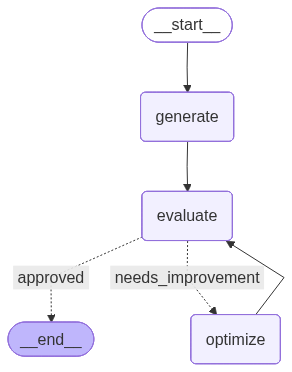

In [26]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

workflow

In [27]:
initial_state = {
    "topic": "srhberhb",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [28]:
result

{'topic': 'srhberhb',
 'tweet': [{'type': 'text',
   'text': 'I’ll type something like “srhberhb” and my phone doesn’t even try to autocorrect it anymore. It just lowers the brightness so no one else can see the breakdown. That’s the only AI I’m interested in.',
   'extras': {'signature': 'Es4fCssfAXLI2nzj1oPXqEIZHkeztnZjS37cGYxqnD8BVcLqTIjVlZF4zSHu/pYnvb8msQy6E3RThl+SbCOavOWWZZva0aQEl4BYEVE2cL2euPu6Tf4A4JJhWME6bGV0PfO+B1DgrQ3Plx2zpVO8fGk4MnD8Teff9wjXy4AdhdTthCaAQ+uu1XxIgKXID7mQW8oi9e5ppUkSG/mcA6lf+1qaz6twDkk7dClSGiVTT8TBX7ROoxbI0cOirIORldUyTkvVVRQ2AlUKfx0O9s5JtKvxWa6/4dl3KewN2hgK+Fis7b+l2WiBrxvNB6dc00BXEywEG/UA2NPmQ34YIErk6l37fbFXYBubdunNL6nk4gKgJEbgIbgQsG6SYUN9VbDCesVsB7Ww/xp3YQFbMwWy1QDcgJu4WYLC3sfaWbrojkuBJ2Sblu4H572oLwR4NMvw+x9V58fce419LiHRpqFMw8MoXRFzo9VOBLUYmralAMQWSigtEyQgdASUw/ZF50xCqo4Nr6DFDU/sxAAL+R9jscv/hSwV3WXfUkp7beFx4IyEjS7/Vu/Pqgh6tLZHHZL9hKUZk5KtxgEHsIPz3SbEDG3k83YCvjmb+/YYKmlVXaZSfEGKwcmtWyuk3aXzhm9jN9uu4SOOPH89hqp5xUMe90j6s10ptk5MYOXMaTri/+g8kII5Xyla+g6nmyaGMAe8lTeup

In [ ]:
for tweet in result['tweet_history']:
    print(tweet)

[{'type': 'text', 'text': '"srhberhb" is the universal sound for when you try to spell "Wednesday" without the help of autocorrect and your brain just decides to give up on the English language entirely.', 'extras': {'signature': 'EvQVCvEVAXLI2nxIxUecFoF4YJvU/dG3+QtxY8t0qJeopM0EThVEW2y17x9qoMAdjoVob8xmPHzVI4+Zxe/PY+/rsPMg1V0mUPJ1PTz/PZhdmAudn9cA4o9Tl6gSGT0NY6D0twKUnEQiL53/XyxDIUKIMXooZSYskrVkNYk0NRcx5lNB3aEnyPg1C6mWgkCIQ5Wh0dMQcb6BHt5wW4/zq4Cf/HiupIg3lJLNqgVl0Ja0S+cnlo0w6ylxoHbk1pQEiG5dIu+W4mkzNvJsAptxyHDndGIGKcBrlZ5XkHPAJ8Yx6jCz6XghrqZW3D6NwEMuvT5P2ry0n6w9uWRhw5ERa2hcEZaJcUgaESuiz/j7n8mabiP9rqVDzjqmNLHIjESZuFt2h0D6v3k+jswvADGVSBFw3Vl18E4+2H6A9L3QAdawD/hGX8IlfGdEVs292V9TWn8RuBcdbgPbd9P93J873lXVjNUKsqMFNzC3g97i059PjVqXb3FpGhbXPDxEr29znA/xdyE0nECfnLcTui8QW4nFy5dCVOa9s1exyjRib7DO2PauY1fbTBrqtALEvrLYdXrcIVEfIBp6w4XtwZ150itU1cn7JdSLNBvX7V5FqO0pqqCNeHPOmkpOmbpkf88Swgs8OrwNa+V3j7Q6FpU8rI8MAf7XRrM/cJwVeEIU7WlyxcdaHsHaMHg6LDTLrNZBnRcdqntIEI++uf8Hp/Ktz1ocdRDSlogxUpsmjFRFGLwEHMzzQH8+j0MxuzSQWZ1x+

: 